In [1]:
##
## VGG16 и VGG19 проверка результативности (реализации взяты с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-09
##  TIF (64,64,6) - полная схема по признакам 4,5,6,7
##
## 2017-07-12
##  JPG+TIF (64x64x)==(128x128x) по результатам
##  BatchNarmalizstion не  поднимает результат
##  Наиболее быстрый и адекватный вариант классификационной части dense1024+dense1024
##  Ввод новых вегетационных признаков типа CCCI не приводит к улучшению. Либо также либо чуть хуже
##
## 2017-07-12
##  Проверяю полный прогон на VGG19 (для очистки совести и перехожу на другое)
##
## 2017-07-12
##  Проверил! LB=0.90004. Вставил VGG19 на наборе jpg128 + подставил насильственно веса от imagenet. Работает на train 9 часов.
##  Необходима специализированная препроцессорная обработка для imagenet (RGB-->BGR; минус спец среднее из изображений)
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [337]:
del(trOX); del(trOY);

In [15]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [338]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    
if False : # VGG16-19
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    print(trX.shape,trY.shape)
    
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-128x128x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0; del trX0
    trX[:,:,:,3:]  = trX1; del trX1
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0
    trX[:,:,:,3:]  = trX1
    #del trX0,trX1
    
if True :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-tif.npy')
    
    trX  = trX[:, :, :, ::-1] # RGB --> BGR
    
    trX  = np.array(trX,dtype=np.float16)
    trX[:, :, :, 0] -= 103.939
    trX[:, :, :, 1] -= 116.779
    trX[:, :, :, 2] -= 123.68
    
print(trX.shape,trY.shape)

(40479, 128, 128, 3) (40479, 17)


In [19]:
#del trX0,trX1,trX

In [23]:
trX00 = trX0.copy()
for i in range(trX00.shape[1]) :
    for j in range(trX00.shape[2]) :
        trX00[:,i,j,:] = trX0[:,j,i,:]

In [31]:
trX[:,:,:,0:3] = trX00

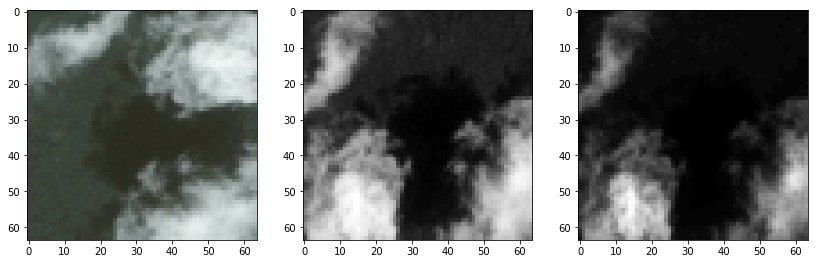

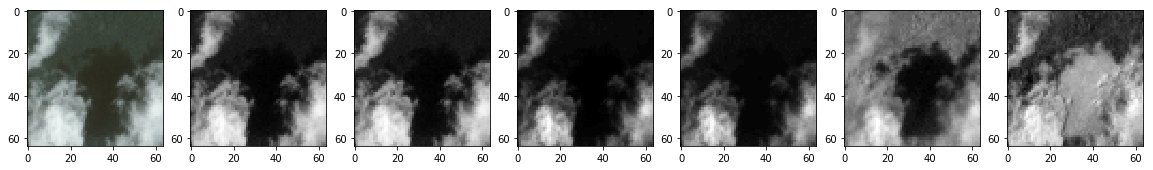

In [205]:
ii = 384
xf = plt.figure(figsize=(14,25))
plt.subplot(131); plt.imshow(trX0[ii]);
plt.subplot(132); plt.imshow(trX00[ii,:,:,1],'gray');
plt.subplot(133); plt.imshow(trX1[ii,:,:,1],'gray');
plt.show();
xf = plt.figure(figsize=(20,25))
plt.subplot(171); plt.imshow(trX[ii,:,:,0:3]);
plt.subplot(172); plt.imshow(trX[ii,:,:,0],'gray');
plt.subplot(173); plt.imshow(trX00[ii,:,:,0],'gray');
plt.subplot(174); plt.imshow(trX[ii,:,:,4],'gray');
plt.subplot(175); plt.imshow(trX[ii,:,:,5],'gray');
plt.subplot(176); plt.imshow(trX[ii,:,:,6],'gray');
plt.subplot(177); plt.imshow(trX[ii,:,:,7],'gray');
plt.show();
plt.close()
#xf.close()

In [183]:
import math 
diffX = np.zeros((trX.shape[0],3),dtype=np.float32)
for ii in range(trX.shape[0]) :
    for cc in range(3) :
        temp0 = (((trX[ii,:,:,cc]-trX[ii,:,:,cc].mean())-(trX[ii,:,:,cc+3]-trX[ii,:,:,cc+3].mean())**2).mean())
        temp1 = (temp0**2).mean()
        if ii<2 : print(ii,cc,temp1)
        diffX[ii,cc] = math.sqrt(temp1);  

0 0 0.0022586415426
0 1 0.057748186312
0 2 0.0635254379204
1 0 1.03568214476
1 1 6.94111424745
1 2 4.8513637982


[(0.17995875, 0.093767121), (1.9516217, 0.68353921), (0.16148543, 0.077598095)]
667
787
728
787


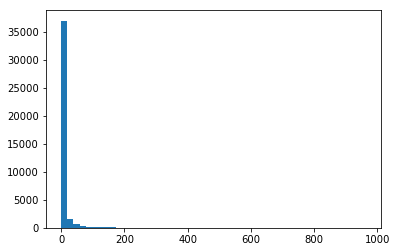

['train_12' 'train_292' 'train_352' 'train_384' 'train_413' 'train_532'
 'train_571' 'train_579' 'train_695' 'train_726']
[[  443.7121582    236.81202698   399.63220215]
 [  143.80715942   139.89042664   123.93715668]
 [ 1431.40356445   489.98242188   802.11126709]
 ..., 
 [  248.40374756   239.036026     210.06066895]
 [  413.96820068   306.89395142   317.39718628]
 [  562.56951904   344.39715576   471.94876099]]


In [203]:
print([(diffX[cc].mean(),diffX[cc].std()) for cc in range(3)])
cc0 = (diffX[:,0]>=100 ) #0.6)
cc1 = (diffX[:,1]>=100 ) #6)
cc2 = (diffX[:,2]>=100 ) #0.6)
ccc = np.logical_and(cc0,np.logical_and(cc1,cc2))

print(len(diffX[ccc]))
print(len(diffX[cc0]))
print(len(diffX[cc1]))
print(len(diffX[cc2]))

ccxx = np.array(nameList)[ccc];

plt.hist(diffX[:,2].ravel(),bins=50); plt.show()

print(ccxx[0:10])
print(diffX[ccc,:])

In [20]:
if False : # построение CCCI
    trX.shape
    ndvi_min, ndvi_max = np.zeros(trX.shape[0],dtype=np.float16), np.zeros(trX.shape[0],dtype=np.float16)
    ccci               = np.zeros((trX.shape[0],trX.shape[1],trX.shape[2]),dtype=np.uint8)
    for ii in range(trX.shape[0]) :
        ndvi_min[ii], ndvi_max[ii] = trX[ii,:,:,0].min(), trX[ii,:,:,0].max()
        ccci[ii] = (trX[ii,:,:,0]-ndvi_min[ii])/(ndvi_max[ii]-ndvi_min[ii])*256.0
    ccci.shape
    trX[:,:,:,3]=ccci
    
    ii = 50
    #plt.imshow(np.array(ccci[ii]*256.0,dtype=np.uint8),'gray'); plt.show()
    #plt.subplot(121);plt.imshow(ccci[ii],'gray'); plt.subplot(122);plt.hist(ccci[ii].ravel(),bins=50); 
    #plt.show()
    plt.subplot(121);plt.imshow(trX[ii,:,:,0],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,0].ravel(),bins=30); 
    plt.show()
    plt.subplot(121);plt.imshow(trX[ii,:,:,1],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,1].ravel(),bins=30); 
    plt.show()

In [21]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 64, 64, 11) (40479, 17)


In [23]:
if False : # Берем все
    # Берем из признаков только 4,5,6,7 - проблемные
    trY_old = trY
    trY=trY[:,4:8]
    print(trX.shape,trY.shape)

In [32]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [33]:
def VGG16XX ( include_top=True, 
              weights='imagenet',
              input_tensor=None, input_shape=None,
              pooling=None,
              classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)
    '''
    
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    ##x = BatchNormalization()(img_input) ##-------------------------------
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(0.25)(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        '''
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        '''
        
        x = Dense(1024, activation='relu', name='fc1')(x) ##
        x = Dropout(0.25)(x)
        x = Dense(1024, activation='relu', name='fc2')(x) ## 
        x = Dropout(0.25)(x)
        
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16XX')
    
    """
    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    """
    return model

In [288]:
def VGG19XX(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG19 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)
    """
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        #x = Dense(4096, activation='relu', name='fc1')(x)
        #x = Dense(4096, activation='relu', name='fc2')(x)
        #x = Dense(classes, activation='softmax', name='predictions')(x)
        
        x = Dense(4096, activation='relu', name='fc1')(x) ##
        x = Dropout(0.25)(x)
        x = Dense(4096, activation='relu', name='fc2')(x) ## 
        x = Dropout(0.25)(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
        
        
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19xx')

    """
    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    """
    return model


In [289]:
#model11 = VGG16XX(input_shape=(128,128,12),classes=4)
#model11.summary()
#del model11

In [294]:
input_shape, output_classes, metric = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], 'acc'
print(input_shape,output_classes)

(128, 128, 3) 17


In [295]:
#del model11, model10

In [296]:
K.clear_session()

model10 = VGG19XX(input_shape=input_shape,classes=output_classes)
#model11.summary()

import h5py
hh5  = h5py.File('../Data-Keras/gitModels/vgg19_weights_tf_dim_ordering_tf_kernels.h5','r')

for ll in model10.layers :
    wb   = ll.get_weights()
    if len(wb)==2 :
        upd  = ''
        hg1  = hh5[ll.name]
        hg1w = hg1.get(ll.name+"_W_1:0")[()]
        hg1b = hg1.get(ll.name+"_b_1:0")[()]
        if wb[0].shape==hg1w.shape : wb[0] = hg1w; upd +='1'
        if wb[1].shape==hg1b.shape : wb[1] = hg1b; upd +='2'
        ll.set_weights(wb)
        print (ll.name,[iwb.shape for iwb in wb],hg1w.shape,hg1b.shape,upd)
    #ll.set_weights([fc1W,fc1B])
hh5.close()
sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

block1_conv1 [(3, 3, 3, 64), (64,)] (3, 3, 3, 64) (64,) 12
block1_conv2 [(3, 3, 64, 64), (64,)] (3, 3, 64, 64) (64,) 12
block2_conv1 [(3, 3, 64, 128), (128,)] (3, 3, 64, 128) (128,) 12
block2_conv2 [(3, 3, 128, 128), (128,)] (3, 3, 128, 128) (128,) 12
block3_conv1 [(3, 3, 128, 256), (256,)] (3, 3, 128, 256) (256,) 12
block3_conv2 [(3, 3, 256, 256), (256,)] (3, 3, 256, 256) (256,) 12
block3_conv3 [(3, 3, 256, 256), (256,)] (3, 3, 256, 256) (256,) 12
block3_conv4 [(3, 3, 256, 256), (256,)] (3, 3, 256, 256) (256,) 12
block4_conv1 [(3, 3, 256, 512), (512,)] (3, 3, 256, 512) (512,) 12
block4_conv2 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block4_conv3 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block4_conv4 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block5_conv1 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block5_conv2 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block5_conv3 [(3, 3, 512, 512), (512,)] (3, 3, 512, 512) (512,) 12
block5_conv

In [85]:
input_shape, output_classes, metric = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], 'acc'
print(input_shape,output_classes)

(64, 64, 11) 17


In [86]:
K.clear_session()
##model10 = VGG16XX(input_shape=input_shape,classes=output_classes)
model10 = VGG19XX(input_shape=input_shape,classes=output_classes)
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 11)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        6400      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [87]:
sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [88]:
if False : model10.load_weights('../Data-Keras/Models/model-Alex-weights-128x128x3.h5', by_name=False)

In [89]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [305]:
epochs     = 50
verbose    = 2
batch_size = 128
stopping   = 10

prefixTemp = 'jpg-tif-64x64xX'     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-.hdf5"
##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

tr1    = np.sum([K.count_params(p) for p in set(model10.trainable_weights)])
tr2    = np.sum([K.count_params(p) for p in set(model10.non_trainable_weights)])

step = 5000
low  = 5000
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

print(datetime.datetime.now(),tr1+tr2)
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX,trY,
                    #sample_weight=sweight[low:high],
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.20, 
                    #initial_epoch=5,
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-12 04:22:39.015989 70433873.0
Train on 32383 samples, validate on 8096 samples
Epoch 1/50
Epoch 00000: acc improved from -inf to 0.85534, saving model to ../Temp/Temp/jpg-tif-64x64xX-weights.00-acc=0.8553-val_acc=0.8512-.hdf5
678s - loss: 0.2661 - acc: 0.8553 - val_loss: 0.2632 - val_acc: 0.8512
Epoch 2/50
Epoch 00001: acc improved from 0.85534 to 0.85544, saving model to ../Temp/Temp/jpg-tif-64x64xX-weights.01-acc=0.8554-val_acc=0.8418-.hdf5
679s - loss: 0.2639 - acc: 0.8554 - val_loss: 0.2649 - val_acc: 0.8418
Epoch 3/50
Epoch 00002: acc did not improve
676s - loss: 0.2619 - acc: 0.8554 - val_loss: 0.2612 - val_acc: 0.8501
Epoch 4/50
Epoch 00003: acc improved from 0.85544 to 0.85553, saving model to ../Temp/Temp/jpg-tif-64x64xX-weights.03-acc=0.8555-val_acc=0.8497-.hdf5
679s - loss: 0.2606 - acc: 0.8555 - val_loss: 0.2600 - val_acc: 0.8497
Epoch 5/50
Epoch 00004: acc improved from 0.85553 to 0.85554, saving model to ../Temp/Temp/jpg-tif-64x64xX-weights.04-acc=0.8555-val_acc=0

In [339]:
trX.shape, trY.shape

((40479, 128, 128, 3), (40479, 17))

In [340]:
%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

CPU times: user 22.4 s, sys: 11.3 s, total: 33.7 s
Wall time: 3min 55s


In [341]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(40479, 17)
(40479, 17)
fbeta_score= 0.223606358247
fbeta_pred = 0.42286061861
fbeta_score= 0.924543623725
fbeta_pred = 0.923238668576


In [300]:
if False :
    freeze  = ('fc1','fc2','dropout_1','dropout_2','flatten')
    trainOK = ('input_1','predictions')
    for layer in model10.layers :
        #if (layer.name=='fc1') : layer.trainable = False
        #if (layer.name=='fc2') : layer.trainable = False
        if (layer.name in freeze) : layer.trainable = False
        else : layer.trainable = True
        if (layer.name in trainOK) : layer.trainable = True
        layer.trainable = True
        print(layer.name,layer.trainable)      

In [343]:
if True :
    save_model(model10,'../Data-Keras/Models/model-VGG19-128x128x3-d4096xd4096.h5')
    model10.save_weights('../Data-Keras/Models/model-VGG19-128x128x3-d4096xd4096-weights.h5')
    if True : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

In [314]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [310]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  3.70237350e-01,   4.93190736e-01,   1.06996112e-03,
          1.33314744e-01,   6.74560608e-04,   9.84107974e-05,
          2.12351413e-04,   4.83186363e-04,   4.88138940e-05,
          1.42483710e-04,   7.10203385e-05,   1.37875631e-05,
          4.31219232e-05,   1.01183177e-05,   1.92909007e-04,
          5.11052203e-05,   1.45314596e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [139]:
# Результативность

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [315]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [316]:
trOX  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-XX.npy').astype(np.float16)
trOY  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-YY.npy')

In [317]:
# Препроцессорная обработка данных

trOX  = trOX[:, :, :, ::-1] # RGB --> BGR

##trX  = np.array(trX,dtype=np.float16)
trOX[:, :, :, 0] -= 103.939
trOX[:, :, :, 1] -= 116.779
trOX[:, :, :, 2] -= 123.68
    


In [319]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test
trOP = model10.predict(trOX, batch_size=batch_size)

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)


In [333]:
#trO01[0:3],np.array(th),trOP[0:3]
if True :
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOY-OY.npy',trOY)

In [320]:
# Строим результат

In [321]:
trZ = trO01

In [322]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [323]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary clear'],
 ['test_4', 'cloudy']]

In [324]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-12-15-25-40


In [325]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,cloudy


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Склад барахла

In [ ]:
Skip to content
Features Business Explore Marketplace Pricing
This repository
Search
Sign in or Sign up
 Watch 1,176  Star 17,415  Fork 6,223 fchollet/keras
 Code  Issues 1,167  Pull requests 36  Projects 1  Wiki Insights 
Branch: master Find file Copy pathkeras/keras/applications/vgg19.py
bac1637  on 22 May
@taehoonlee taehoonlee Fix typos (#6702)
4 contributors @fchollet @taehoonlee @singlas @ozancaglayan
RawBlameHistory     
193 lines (167 sloc)  8.29 KB
# -*- coding: utf-8 -*-
"""VGG19 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from ..models import Model
from ..layers import Flatten
from ..layers import Dense
from ..layers import Input
from ..layers import Conv2D
from ..layers import MaxPooling2D
from ..layers import GlobalAveragePooling2D
from ..layers import GlobalMaxPooling2D
from ..engine.topology import get_source_inputs
from ..utils import layer_utils
from ..utils.data_utils import get_file
from .. import backend as K
from .imagenet_utils import decode_predictions
from .imagenet_utils import preprocess_input
from .imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG19 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
Contact GitHub API Training Shop Blog About
© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [ ]:
def VGG16 ( include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [209]:
if False :
    from keras.utils.data_utils import get_file
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
    WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        WEIGHTS_PATH,
                                        cache_subdir='models')


In [ ]:
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models')

In [27]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)



In [93]:
K.clear_session()

In [83]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=False)
model10 = VGG16(weights=None,input_shape=(224,224,3),include_top=True,classes=4)

#x = (Dense(512,activation='relu'))(model10)
#model10.add(Dropout(0.25))
#model10.add(Dense(4,activation='sigmoid'))

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

In [114]:
#model10.summary()